In [ ]:
# !pip install jupyter_http_over_ws
# !jupyter server extension enable --py jupyter_http_over_ws
# !pip install google

# !pip install tensorflow
# !pip install google.colab
# !pip install setuptools
# !pip install ez_setup

# !pip install google.colab

# import tensorflow as tf


In [ ]:
# !pip install PyDrive2
# from pydrive2.auth import GoogleAuth

# gauth = GoogleAuth()
# gauth.LocalWebserverAuth() # Creates local webserver and auto handles authentication.

# from pydrive.drive import GoogleDrive

# drive = GoogleDrive(gauth)

In [ ]:
import tensorflow as tf

# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory("/content/drive/MyDrive/Shroomies/BackendTeam/Train")
ds_train = tf.keras.preprocessing.image_dataset_from_directory("/content/drive/MyDrive/Shroomies/BackendTeam/Train", validation_split=0.2, subset="training", seed=123)
ds_validation = tf.keras.preprocessing.image_dataset_from_directory("/content/drive/MyDrive/Shroomies/BackendTeam/Train", validation_split=0.2, subset="validation", seed=123)

# For local testing, if on Hosted gpu use above files
# file_directory = 'G:\MyDrive\Shroomies\BackendTeam\Train'
# dataset = tf.keras.preprocessing.image_dataset_from_directory(file_directory)
# ds_train = tf.keras.preprocessing.image_dataset_from_directory(file_directory, validation_split=0.2, subset="training", seed=123)
# ds_validation = tf.keras.preprocessing.image_dataset_from_directory(file_directory, validation_split=0.2, subset="validation", seed=123)

Found 1826 files belonging to 2 classes.
Found 1826 files belonging to 2 classes.
Using 1461 files for training.
Found 1826 files belonging to 2 classes.
Using 365 files for validation.


In [ ]:
print(ds_train)
print(ds_validation)
print(dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
import tensorflow_datasets as tfds
#batch size is basically dividing the subsets of the data into smaller chunks that a model can understand
batch_size = 32

dataset_name = dataset
class_names = dataset.class_names
print(class_names)

['edible sporocarp', 'poisonous sporocarp']


In [ ]:
#standardizing our dataset
size = (512, 512)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_val = ds_validation.map(lambda image, label: (tf.image.resize(image, size), label))

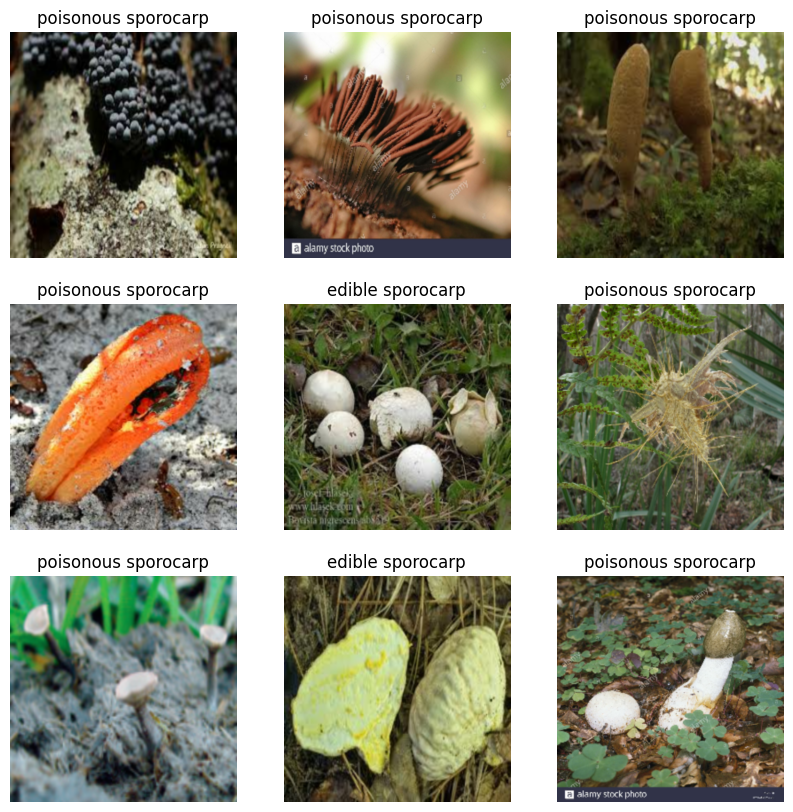

In [ ]:
#display images
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images, labels in ds_train.take(1):
  for i in range (9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
#we can do even more preprocessing to increase the instances of an image (basically get our moneys worth LETS GOOO)
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

image = Sequential (
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(height_factor=(-0.2, -0.3), width_factor=(-0.2, -0.3), interpolation="bilinear"),
        layers.RandomContrast(factor=0.1),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    ],
    name="image"
)

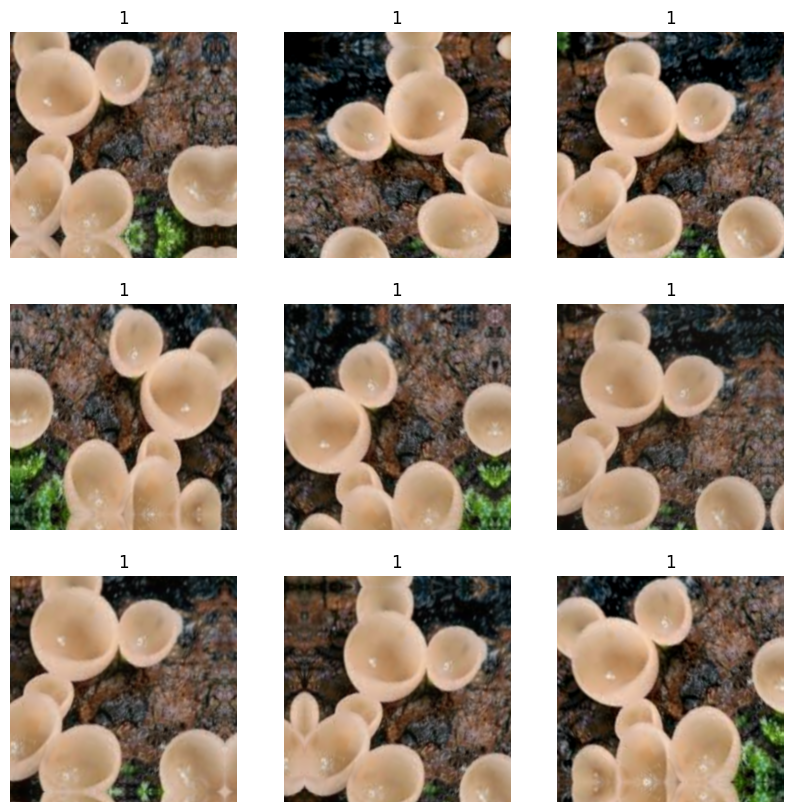

In [ ]:
#lets see what them bad boys look like now
import numpy as np

for images, labels in ds_train.take(1):
  plt.figure(figsize=(10,10))
  first_image = images[0]
  def f(x):
    return np.int_(x)
  f2 = np.vectorize(f)
  for i in range (9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = image(
        tf.expand_dims(first_image, 0), training=True
    )
    plt.imshow(augmented_image[0].numpy().astype("int32"))
    plt.title(f2(labels[0])) #1 = poisonous
    plt.axis("off")

In [ ]:
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

Setting, training, testing the model


In [ ]:
#Instantiating our model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers


resnet_model = Sequential()
pre_trained_Model = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(512, 512, 3),
    pooling=None,
    classes=2,

)

#We don't want to retrain the pre trained model
for layer in pre_trained_Model.layers:
  layer.trainable = False

resnet_model.add(pre_trained_Model)
resnet_model.add(layers.Flatten())
resnet_model.add(layers.Dense(512, activation='relu'))
resnet_model.add(layers.Dense(5, activation= 'sigmoid'))

94765736/94765736 [==============================] - 4s 0us/step


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 16, 16, 2048)      23587712  
                                                                 
 flatten (Flatten)           (None, 524288)            0         
                                                                 
 dense (Dense)               (None, 512)               268435968 
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 292026245 (1.09 GB)
Trainable params: 268438533 (1.00 GB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [ ]:
#
from tensorflow.keras.optimizers import Adam

resnet_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
ds_train, ds_val, ds_validation,

(<_MapDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_MapDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

In [ ]:
#For reference
#dataset = tf.keras.preprocessing.image_dataset_from_directory("/content/drive/MyDrive/Shroomies/BackendTeam/Train")
# ds_train = tf.keras.preprocessing.image_dataset_from_directory("/content/drive/MyDrive/Shroomies/BackendTeam/Train", validation_split=0.2, subset="training", seed=123)
# ds_validation = tf.keras.preprocessing.image_dataset_from_directory("/content/drive/MyDrive/Shroomies/BackendTeam/Train", validation_split=0.2, subset="validation", seed=123)
#
epochs = 10
history = resnet_model.fit(
    ds_train,
    batch_size=32,
    validation_data = ds_val,
    epochs=epochs
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


46/46 [==============================] - 560s 12s/step - loss: 99.1071 - accuracy: 0.7399 - val_loss: 44.3791 - val_accuracy: 0.8110
Epoch 2/10
46/46 [==============================] - 535s 12s/step - loss: 14.9560 - accuracy: 0.9268 - val_loss: 51.2581 - val_accuracy: 0.8658
Epoch 3/10
46/46 [==============================] - 537s 12s/step - loss: 3.1166 - accuracy: 0.9815 - val_loss: 41.5553 - val_accuracy: 0.8712
Epoch 4/10
46/46 [==============================] - 544s 12s/step - loss: 0.9261 - accuracy: 0.9877 - val_loss: 45.9696 - val_accuracy: 0.8685
Epoch 5/10
46/46 [==============================] - 548s 12s/step - loss: 1.4620 - accuracy: 0.9856 - val_loss: 39.1196 - val_accuracy: 0.8822
Epoch 6/10
46/46 [==============================] - 544s 12s/step - loss: 0.7050 - accuracy: 0.9938 - val_loss: 41.5355 - val_accuracy: 0.8849
Epoch 7/10
46/46 [==============================] - 539s 12s/step - loss: 0.3958 - accuracy: 0.9973 - val_loss: 52.3074 - val_accuracy: 0.8630
Epoch 8/

In [ ]:
history.history

{'loss': [99.10713195800781,
  14.955960273742676,
  3.116607427597046,
  0.9261133074760437,
  1.4619615077972412,
  0.7050161957740784,
  0.3957836925983429,
  0.2949364185333252,
  0.3703295886516571,
  1.1084502935409546],
 'accuracy': [0.7399041652679443,
  0.9267624616622925,
  0.9815195202827454,
  0.987679660320282,
  0.9856262803077698,
  0.9938398599624634,
  0.9972621202468872,
  0.9965776801109314,
  0.995208740234375,
  0.9911019802093506],
 'val_loss': [44.37910079956055,
  51.25812911987305,
  41.55527114868164,
  45.96962356567383,
  39.11962127685547,
  41.535491943359375,
  52.30739974975586,
  52.673431396484375,
  54.13188552856445,
  50.01868438720703],
 'val_accuracy': [0.8109589219093323,
  0.8657534122467041,
  0.8712328672409058,
  0.8684931397438049,
  0.8821917772293091,
  0.8849315047264099,
  0.8630136847496033,
  0.8712328672409058,
  0.8712328672409058,
  0.8684931397438049]}

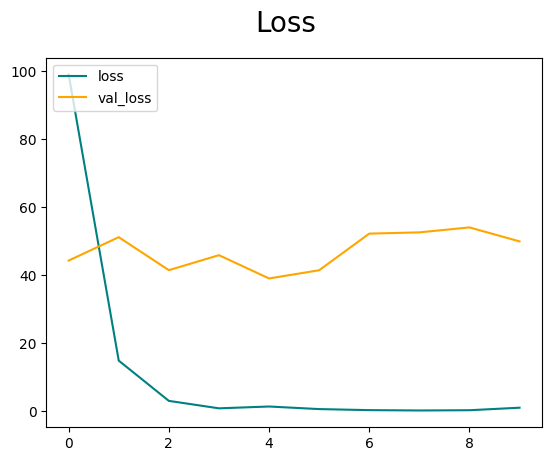

In [ ]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

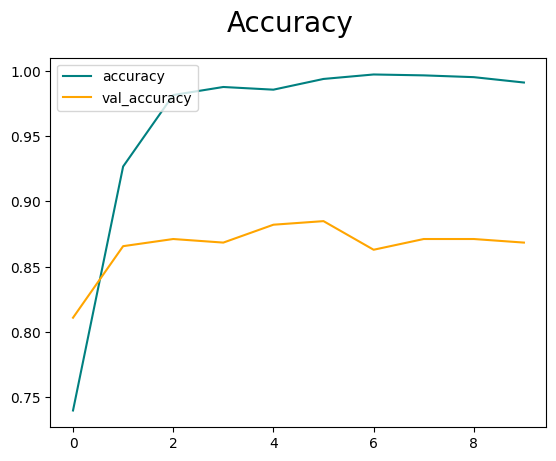

In [ ]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

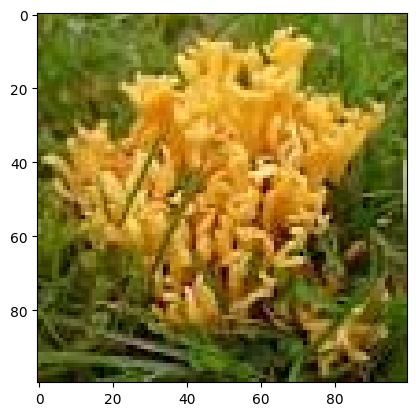

In [ ]:
import cv2
test_image =  '/content/drive/MyDrive/Shroomies/BackendTeam/Train/poisonous sporocarp/nncv (1029).jpg' #edit later
numpy_im = cv2.imread(test_image)
plt.imshow(cv2.cvtColor(numpy_im, cv2.COLOR_BGR2RGB))
# resized_img = cv2.resize(numpy_im, (512, 512))
# resnet_model.predict(resized_img)

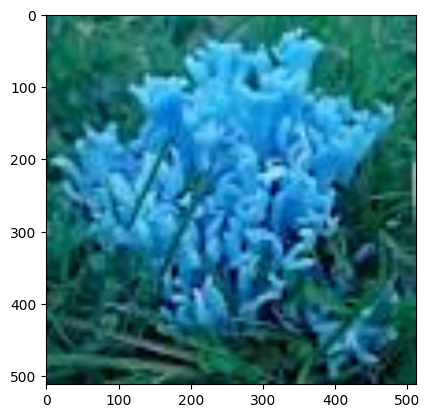

In [ ]:
resize = tf.image.resize(numpy_im, (512,512))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
# pred = resnet_model.predict(np.expand_dims(resize/255, 0))
# pred
# print(pred >= 1)

img = tf.keras.utils.load_img(
    test_image, target_size=(512, 512)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = resnet_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(predictions)
print(score)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


1/1 [==============================] - 0s 389ms/step
[[1. 1. 0. 0. 0.]]
tf.Tensor([0.3222025  0.3222025  0.11853168 0.11853168 0.11853168], shape=(5,), dtype=float32)
This image most likely belongs to edible sporocarp with a 32.22 percent confidence.


Saving the model into our shared Shroomies drive


In [ ]:
from tensorflow.keras.models import load_model
import shutil
resnet_model.save('trained_Mushroom_model','/content/drive/MyDrive/Shroomies/BackendTeam/Saved-Models', save_format='h5')

# shutil.copy("/content/trained_Mushroom_model","/content/drive/MyDrive/Shroomies/BackendTeam/Saved-Models")


source = "/content/trained_Mushroom_model"

# Destination path
destination = "/content/drive/MyDrive/Shroomies/BackendTeam/Saved-Models"

# Copy the content of
# source to destination

try:
    shutil.copy(source, destination)
    print("File copied successfully.")

# If source and destination are same
except shutil.SameFileError:
    print("Source and destination represents the same file.")

# If there is any permission issue
except PermissionError:
    print("Permission denied.")

# For other errors
except:
    print("Error occurred while copying file.")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


File copied successfully.
